# Notebook 03: Volatility Spillover Analysis

## Objective
Quantify volatility spillovers across assets using VAR-based Diebold-Yilmaz framework.

## Inputs
- `all_assets_log_returns_cleaned.csv` – Log-returns for 7 assets

## Outputs
- `gfevd_row_normalized_H10.csv` – Generalized FEVD matrix
- `spillover_table_percent_H10.csv` – Spillover percentages
- `spillover_indices_H10.csv` – Directional & Net spillovers
- Rolling spillover CSVs and plots

## 1. VAR Model Selection & Estimation + DY Spillovers

In [21]:
# === VAR → Generalized FEVD → Diebold–Yilmaz Spillovers  ===
# Requires: pandas, numpy, statsmodels, matplotlib
import numpy as np
import pandas as pd
from pathlib import Path

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# -----------------------
# 0) Load log returns
# -----------------------
CANDIDATES = [
    "all_assets_log_returns_cleaned.csv",
    "data/all_assets_log_returns_cleaned.csv",
    "/mnt/data/all_assets_log_returns_cleaned.csv",
]
FILE = next((p for p in CANDIDATES if Path(p).exists()), None)
if FILE is None:
    raise FileNotFoundError("Update path to 'all_assets_log_returns_cleaned.csv'.")

df = pd.read_csv(FILE, index_col=0, parse_dates=True)
df.index.name = "Date"
df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

# Optional study window
df = df.loc["2005-01-01":]

print(f"[LOAD] returns shape={df.shape}, span=({df.index.min().date()} → {df.index.max().date()})")
print("[LOAD] assets:", list(df.columns))

# -----------------------
# 1) Utilities
# -----------------------
def ensure_clean_panel(x: pd.DataFrame, min_obs: int = 1500) -> pd.DataFrame:
    x = x.sort_index().copy()
    ok = [c for c in x.columns if x[c].dropna().shape[0] >= min_obs]
    x = x[ok].dropna(how="any")
    x = x.loc[:, x.var() > 0]
    return x

def stationarity_report(x: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in x.columns:
        s = x[c].dropna()
        if s.nunique() < 3 or len(s) < 20:
            rows.append({"asset": c, "adf_stat": np.nan, "pvalue": np.nan,
                         "usedlag": np.nan, "nobs": len(s)})
            continue
        stat, p, usedlag, nobs, crit, icbest = adfuller(s.values, regression="c", autolag="AIC")
        rows.append({"asset": c, "adf_stat": float(stat), "pvalue": float(p),
                     "usedlag": int(usedlag), "nobs": int(nobs)})
    return pd.DataFrame(rows).set_index("asset").sort_values("pvalue")

def select_var_lag_ic(x: pd.DataFrame, maxlags: int = 15) -> int:
    """IC-based lag selection. Prefer BIC, then HQIC, then AIC, then FPE."""
    sel = VAR(x).select_order(maxlags=maxlags)

    def _best(v):
        if v is None:
            return None
        arr = np.asarray(v)
        if arr.ndim == 0:
            return 1
        return int(arr.argmin() + 1)

    for pref in ["bic", "hqic", "aic", "fpe"]:
        b = _best(getattr(sel, pref, None))
        if b is not None and b > 0:
            return b
    return 1

def stability_report(var_res, outdir="outputs/var_stage"):
    """Correct stability check for statsmodels VAR: all |roots| > 1."""
    roots = np.asarray(var_res.roots, dtype=complex)
    mod = np.abs(roots)
    rho = float(mod.max())  # spectral radius
    is_stable = (mod > 1).all()

    Path(outdir).mkdir(parents=True, exist_ok=True)
    pd.DataFrame({
        "root_real": np.real(roots),
        "root_imag": np.imag(roots),
        "modulus": mod
    }).sort_values("modulus", ascending=False).to_csv(Path(outdir) / "companion_roots.csv", index=False)

    print("\n[STABILITY REPORT]")
    print("Stable VAR?            ", is_stable)
    print("Max modulus (ρ)        ", round(rho, 6))
    print("Min modulus            ", round(float(mod.min()), 6))
    return is_stable, rho

# -----------------------
# 2) Clean, stationarity, lag, VAR fit
# -----------------------
panel = ensure_clean_panel(df, min_obs=1500)
print(f"[CLEAN] panel shape={panel.shape}")

adf_rep = stationarity_report(panel)
print("\n[ADF] (first 5 rows)\n", adf_rep.head())

lag = select_var_lag_ic(panel, maxlags=15)
print(f"\n[LAG] Using lag={lag} from IC selection.")

var_res = VAR(panel).fit(lag)

# Correct (statsmodels) stability check: all |roots| > 1 means STABLE
stable, rho = stability_report(var_res)

# -----------------------
# 3) Generalized FEVD (Pesaran–Shin) at horizon H
# -----------------------
def generalized_fevd(var_res, H: int = 10) -> pd.DataFrame:
    """
    Compute finite-horizon Pesaran–Shin generalized FEVD.
    Returns KxK BEFORE row-normalization (rows: affected i, cols: shock j).
    """
    Sigma = np.asarray(var_res.sigma_u, dtype=float)     # KxK
    Psi = np.asarray(var_res.ma_rep(H), dtype=float)     # HxKxK
    K = Sigma.shape[0]

    fevd = np.zeros((K, K), dtype=float)

    # Denominator for each i: sum_{h=0}^{H-1} e_i' Psi_h Sigma Psi_h' e_i
    denom = np.zeros(K, dtype=float)
    for h in range(H):
        A = Psi[h] @ Sigma @ Psi[h].T
        denom += np.diag(A)

    sigma_diag = np.diag(Sigma)
    for i in range(K):
        for j in range(K):
            num = 0.0
            for h in range(H):
                v = (Psi[h] @ Sigma)[:, j]  # K-vector
                num += (v[i]) ** 2
            fevd[i, j] = (num / sigma_diag[j]) / denom[i] if denom[i] > 0 else np.nan

    names = var_res.model.endog_names
    return pd.DataFrame(fevd, index=names, columns=names)

H = 10
G = generalized_fevd(var_res, H=H)          # raw generalized FEVD
G_norm = G.div(G.sum(axis=1), axis=0)       # row-normalize → rows sum to 1
row_sums = G_norm.sum(axis=1).to_numpy()
print("\n[CHECK] Row sums (should be 1.0):", np.round(row_sums, 6))
print("[CHECK] Max |row_sum - 1|:", float(np.max(np.abs(row_sums - 1.0))))

# -----------------------
# 4) Diebold–Yilmaz spillover indices
# -----------------------
S = 100.0 * G_norm
K = S.shape[0]
off_diag_sum = S.values.sum() - np.trace(S.values)
total_spillover = off_diag_sum / K

directional_from = S.sum(axis=1) - np.diag(S.values)  # i RECEIVES from others
directional_to   = S.sum(axis=0) - np.diag(S.values)  # i TRANSMITS to others
net_spillover    = directional_to - directional_from  # TO - FROM

print(f"\n[TOTAL SPILLOVER] (H={H}): {total_spillover:.2f}%")
print("\n[DIRECTIONAL FROM] (% of i's variance due to others):")
print(directional_from.round(2).to_string())
print("\n[DIRECTIONAL TO] (% of others' variance due to i):")
print(directional_to.round(2).to_string())
print("\n[NET SPILLOVER] (TO - FROM):")
print(net_spillover.round(2).to_string())

# -----------------------
# 5) Save all outputs
# -----------------------
out_sp = Path("outputs/spillovers"); out_sp.mkdir(parents=True, exist_ok=True)
out_var = Path("outputs/var_stage"); out_var.mkdir(parents=True, exist_ok=True)

# Text + CSV artefacts
with open(out_var / "var_summary.txt", "w") as f:
    f.write(str(var_res.summary()))
adf_rep.to_csv(out_var / "adf_report.csv")

G.to_csv(out_sp / f"gfevd_raw_H{H}.csv")
G_norm.to_csv(out_sp / f"gfevd_row_normalized_H{H}.csv")       # rows sum to 1
S.to_csv(out_sp / f"spillover_table_percent_H{H}.csv")
pd.DataFrame({
    "Directional_FROM": directional_from,
    "Directional_TO": directional_to,
    "Net": net_spillover
}).to_csv(out_sp / f"spillover_indices_H{H}.csv")

# -----------------------
# 6) Quick visuals (PNG)
# -----------------------
plt.figure(figsize=(8, 6))
plt.imshow(S.values, aspect='auto')
plt.xticks(ticks=range(K), labels=S.columns, rotation=45, ha='right')
plt.yticks(ticks=range(K), labels=S.index)
plt.title(f"Spillover Table (%), H={H}")
plt.colorbar()
plt.tight_layout()
plt.savefig(out_sp / f"spillover_heatmap_H{H}.png", dpi=200)
plt.close()

plt.figure(figsize=(8, 4.5))
(net_spillover.sort_values()).plot(kind="bar")
plt.title("Net Spillovers (TO - FROM), %")
plt.tight_layout()
plt.savefig(out_sp / "net_spillovers_bar.png", dpi=200)
plt.close()

print(f"\n[SAVED] All outputs → {out_sp.resolve()} and {out_var.resolve()}")
print("[DONE]")


[LOAD] returns shape=(5093, 7), span=(2005-03-04 → 2025-06-27)
[LOAD] assets: ['S&P_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
[CLEAN] panel shape=(5093, 7)

[ADF] (first 5 rows)
           adf_stat        pvalue  usedlag  nobs
asset                                          
IEF     -53.453110  0.000000e+00        1  5091
Gold    -24.334944  0.000000e+00        8  5084
Wheat   -70.614082  0.000000e+00        0  5092
PBW     -21.755480  0.000000e+00        9  5083
S&P_500 -18.036503  2.666070e-30       15  5077


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[LAG] Using lag=1 from IC selection.

[STABILITY REPORT]
Stable VAR?             True
Max modulus (ρ)         73.634734
Min modulus             6.730671

[CHECK] Row sums (should be 1.0): [1. 1. 1. 1. 1. 1. 1.]
[CHECK] Max |row_sum - 1|: 4.440892098500626e-16

[TOTAL SPILLOVER] (H=10): 20.70%

[DIRECTIONAL FROM] (% of i's variance due to others):
S&P_500        42.50
IEF            17.12
Gold            9.64
Wheat           7.80
Natural_Gas     4.27
Crude_Oil      22.53
PBW            41.01

[DIRECTIONAL TO] (% of others' variance due to i):
S&P_500        48.86
IEF            13.56
Gold            7.89
Wheat           6.43
Natural_Gas     3.32
Crude_Oil      21.17
PBW            43.65

[NET SPILLOVER] (TO - FROM):
S&P_500        6.36
IEF           -3.56
Gold          -1.75
Wheat         -1.37
Natural_Gas   -0.95
Crude_Oil     -1.36
PBW            2.64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[SAVED] All outputs → /Users/mileshobson/outputs/spillovers and /Users/mileshobson/outputs/var_stage
[DONE]


## 2. Rolling Diebold-Yilmaz Spillover Indices

In [49]:
# === Rolling Diebold–Yilmaz Total Connectedness (Mac-ready) ===
# Requirements: pandas, numpy, statsmodels, matplotlib
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.api import VAR

# -----------------------
# Config
# -----------------------
CSV_CANDIDATES = [
    "all_assets_log_returns_cleaned.csv",
    "data/all_assets_log_returns_cleaned.csv",
    "/mnt/data/all_assets_log_returns_cleaned.csv",
]
STUDY_START = "2005-01-01"
WINDOW = 250            # trading days (~1Y)
STEP = 5                # slide step (days)
H = 10                  # FEVD forecast horizon
LAG_MODE = "fixed"      # "fixed" or "ic"
FIXED_LAG = 1           # used when LAG_MODE == "fixed"
MAXLAGS_IC = 15         # max lags considered when LAG_MODE == "ic"
SAVE_DIRECTIONALS = True  # also save TO/FROM/Net per asset (optional)

# -----------------------
# Load & prep
# -----------------------
FILE = next((p for p in CSV_CANDIDATES if Path(p).exists()), None)
if FILE is None:
    raise FileNotFoundError("Update path to 'all_assets_log_returns_cleaned.csv'.")

df = pd.read_csv(FILE, index_col=0, parse_dates=True)
df.index.name = "Date"
df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")
df = df.loc[STUDY_START:]
assets = list(df.columns)

print(f"[LOAD] {FILE} shape={df.shape} | assets={assets}")

# -----------------------
# Helpers
# -----------------------
def select_var_lag_ic(x: pd.DataFrame, maxlags: int = 15) -> int:
    sel = VAR(x).select_order(maxlags=maxlags)
    def _best(v):
        if v is None: return None
        arr = np.asarray(v)
        if arr.ndim == 0: return 1
        return int(arr.argmin() + 1)
    for pref in ["bic", "hqic", "aic", "fpe"]:
        b = _best(getattr(sel, pref, None))
        if b and b > 0: return b
    return 1

def generalized_fevd(var_res, H: int = 10) -> pd.DataFrame:
    Sigma = np.asarray(var_res.sigma_u, dtype=float)
    Psi = np.asarray(var_res.ma_rep(H), dtype=float)
    K = Sigma.shape[0]
    fevd = np.zeros((K, K), dtype=float)
    denom = np.zeros(K, dtype=float)
    for h in range(H):
        A = Psi[h] @ Sigma @ Psi[h].T
        denom += np.diag(A)
    sigma_diag = np.diag(Sigma)
    for i in range(K):
        for j in range(K):
            num = 0.0
            for h in range(H):
                v = (Psi[h] @ Sigma)[:, j]
                num += (v[i]) ** 2
            fevd[i, j] = (num / sigma_diag[j]) / denom[i] if denom[i] > 0 else np.nan
    names = var_res.model.endog_names
    return pd.DataFrame(fevd, index=names, columns=names)

def spillover_from_varres(var_res, H: int = 10):
    """Return (total, S%, directional_from, directional_to, net)"""
    G = generalized_fevd(var_res, H=H)
    G_norm = G.div(G.sum(axis=1), axis=0)
    S = 100.0 * G_norm
    K = S.shape[0]
    off_diag_sum = S.values.sum() - np.trace(S.values)
    total = off_diag_sum / K
    directional_from = S.sum(axis=1) - np.diag(S.values)
    directional_to   = S.sum(axis=0) - np.diag(S.values)
    net = directional_to - directional_from
    return total, S, directional_from, directional_to, net

# -----------------------
# Rolling computation
# -----------------------
dates = df.index
out_total = []
out_dates = []
out_to = []
out_from = []
out_net = []

for start in range(0, len(dates) - WINDOW + 1, STEP):
    end = start + WINDOW
    sub = df.iloc[start:end].copy()
    sub_dates = (sub.index[0], sub.index[-1])

    # Basic guard: drop any constant columns in window
    keep = sub.columns[sub.std(ddof=1) > 0]
    sub = sub[keep]
    if sub.shape[1] < 2:
        continue

    # Choose lag
    if LAG_MODE == "ic":
        lag = select_var_lag_ic(sub, maxlags=MAXLAGS_IC)
    else:
        lag = FIXED_LAG

    try:
        var_res = VAR(sub).fit(lag)
        # Stability in statsmodels: all |roots| > 1 is STABLE
        if not (np.abs(var_res.roots) > 1).all():
            # If unstable, skip (or you could fallback to lag=1)
            print(f"[SKIP] Unstable VAR at window {sub_dates} (lag={lag})")
            continue
        total, S, d_from, d_to, net = spillover_from_varres(var_res, H=H)

        out_total.append(float(total))
        out_dates.append(sub.index[-1])  # anchor at window end

        if SAVE_DIRECTIONALS:
            out_to.append(d_to.reindex(assets, fill_value=np.nan).values)
            out_from.append(d_from.reindex(assets, fill_value=np.nan).values)
            out_net.append(net.reindex(assets, fill_value=np.nan).values)

        if (len(out_total) % 50) == 0:
            print(f"[ROLL] {len(out_total)} windows processed; last total={total:.2f}% at {sub.index[-1].date()}")
    except Exception as e:
        print(f"[WARN] window {sub_dates} failed: {e}")

# -----------------------
# Save results
# -----------------------
outdir = Path("outputs/rolling"); outdir.mkdir(parents=True, exist_ok=True)

roll = pd.DataFrame({"Total_Spillover": out_total}, index=pd.to_datetime(out_dates))
roll.index.name = "Date"
roll.to_csv(outdir / f"rolling_total_H{H}_W{WINDOW}_S{STEP}_{LAG_MODE}.csv")

if SAVE_DIRECTIONALS and len(out_total) > 0:
    df_to   = pd.DataFrame(np.vstack(out_to),   index=roll.index, columns=assets)
    df_from = pd.DataFrame(np.vstack(out_from), index=roll.index, columns=assets)
    df_net  = pd.DataFrame(np.vstack(out_net),  index=roll.index, columns=assets)
    df_to.to_csv(outdir / f"rolling_to_H{H}_W{WINDOW}_S{STEP}_{LAG_MODE}.csv")
    df_from.to_csv(outdir / f"rolling_from_H{H}_W{WINDOW}_S{STEP}_{LAG_MODE}.csv")
    df_net.to_csv(outdir / f"rolling_net_H{H}_W{WINDOW}_S{STEP}_{LAG_MODE}.csv")

print(f"[SAVED] Rolling totals → {outdir.resolve()}")

# -----------------------
# Plot
# -----------------------
plt.figure(figsize=(10, 4.5))
roll["Total_Spillover"].plot()
plt.title(f"Rolling Total Spillover Index (H={H}, W={WINDOW}, step={STEP}, lag={LAG_MODE if LAG_MODE=='fixed' else 'IC'})")
plt.ylabel("Percent")
plt.xlabel("")
plt.tight_layout()
plt.savefig(outdir / f"rolling_total_H{H}_W{WINDOW}_S{STEP}_{LAG_MODE}.png", dpi=200)
plt.close()

print("[DONE]")



[LOAD] all_assets_log_returns_cleaned.csv shape=(5093, 7) | assets=['S&P_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
[ROLL] 50 windows processed; last total=22.57% at 2007-03-12


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 100 windows processed; last total=28.00% at 2008-03-07
[ROLL] 150 windows processed; last total=39.61% at 2009-03-05


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 200 windows processed; last total=39.21% at 2010-03-03
[ROLL] 250 windows processed; last total=32.78% at 2011-02-28


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 300 windows processed; last total=38.53% at 2012-02-24
[ROLL] 350 windows processed; last total=36.45% at 2013-02-25


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 400 windows processed; last total=19.59% at 2014-02-21
[ROLL] 450 windows processed; last total=24.87% at 2015-02-19
[ROLL] 500 windows processed; last total=24.27% at 2016-02-17


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 550 windows processed; last total=26.32% at 2017-02-15
[ROLL] 600 windows processed; last total=21.75% at 2018-02-15
[ROLL] 650 windows processed; last total=22.21% at 2019-02-14


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 700 windows processed; last total=29.98% at 2020-02-12
[ROLL] 750 windows processed; last total=26.15% at 2021-02-11
[ROLL] 800 windows processed; last total=18.07% at 2022-02-08


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[ROLL] 850 windows processed; last total=26.89% at 2023-02-07
[ROLL] 900 windows processed; last total=19.27% at 2024-02-06
[ROLL] 950 windows processed; last total=14.72% at 2025-02-05


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dat

[SAVED] Rolling totals → /Users/mileshobson/outputs/rolling
[DONE]


## 3. Visualisation

In [52]:
# === Plot Rolling Net Spillovers per Asset ===
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path

outdir = Path("outputs/rolling")
H = 10
W = 250
STEP = 5
LAG_MODE = "fixed"

net_file = outdir / f"rolling_net_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv"
df_net = pd.read_csv(net_file, index_col=0, parse_dates=True)

plt.figure(figsize=(10, 5))
for col in df_net.columns:
    plt.plot(df_net.index, df_net[col], label=col)
plt.axhline(0, color="black", lw=0.8)
plt.title(f"Rolling Net Spillovers per Asset (H={H}, W={W})")
plt.ylabel("Net Spillover (TO - FROM, %)")
plt.xlabel("")
plt.legend(loc="upper right", ncol=3, fontsize=8)
plt.tight_layout()
plt.savefig(outdir / f"rolling_net_spillovers_H{H}_W{W}.png", dpi=200)
plt.close()

print(f"[SAVED] → {outdir / f'rolling_net_spillovers_H{H}_W{W}.png'}")

# === Optional: Rolling Directional TO and FROM plots ===
df_to = pd.read_csv(outdir / f"rolling_to_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv", index_col=0, parse_dates=True)
df_from = pd.read_csv(outdir / f"rolling_from_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv", index_col=0, parse_dates=True)

for name, df_ in [("TO", df_to), ("FROM", df_from)]:
    plt.figure(figsize=(10, 5))
    for col in df_.columns:
        plt.plot(df_.index, df_[col], label=col)
    plt.title(f"Rolling Directional {name} Spillovers (H={H}, W={W})")
    plt.ylabel(f"{name} Spillover (%)")
    plt.xlabel("")
    plt.legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    plt.savefig(outdir / f"rolling_{name.lower()}_spillovers_H{H}_W{W}.png", dpi=200)
    plt.close()
    print(f"[SAVED] → {outdir / f'rolling_{name.lower()}_spillovers_H{H}_W{W}.png'}")


[SAVED] → outputs/rolling/rolling_net_spillovers_H10_W250.png
[SAVED] → outputs/rolling/rolling_to_spillovers_H10_W250.png
[SAVED] → outputs/rolling/rolling_from_spillovers_H10_W250.png


In [67]:
# === Publication-Ready Plots: Rolling Spillovers + DCC Correlations + Conditional Volatility ===
# Dependencies: pandas, numpy, matplotlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# -----------------------
# Config (match your rolling run)
# -----------------------
H, W, STEP, LAG_MODE = 10, 250, 5, "fixed"
ANCHOR = "S&P_500"                 # correlation anchor
SMOOTH = 3                         # centered moving-average (plot smoothing)
USE_VOL = True                     # overlay conditional vols if available

# Inputs
OUTDIR = Path("outputs/rolling")
DCC_FILE = Path("dcc_correlations.csv")              # long format: Date, Asset1, Asset2, Pair, Correlation
VOL_FILE = Path("all_assets_conditional_vol.csv")    # wide format: Date index, columns = assets

# Crisis shading windows (edit as you like)
CRISES = [
    ("2007-07-01", "2009-06-30", "GFC"),
    ("2010-05-01", "2012-12-31", "Euro Debt"),
    ("2020-02-15", "2020-12-31", "COVID"),
    ("2022-02-01", "2023-12-31", "Ukraine/Inflation"),
]

# -----------------------
# Load rolling outputs
# -----------------------
to_path   = OUTDIR / f"rolling_to_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv"
from_path = OUTDIR / f"rolling_from_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv"
net_path  = OUTDIR / f"rolling_net_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv"

df_to   = pd.read_csv(to_path,   index_col=0, parse_dates=True)
df_from = pd.read_csv(from_path, index_col=0, parse_dates=True)
df_net  = pd.read_csv(net_path,  index_col=0, parse_dates=True)
assets  = list(df_net.columns)

# -----------------------
# Helpers
# -----------------------
def smooth(df, k=SMOOTH):
    if k and k > 1:
        return df.rolling(k, center=True, min_periods=max(1, k//2)).mean()
    return df

def shade(ax):
    y0, y1 = ax.get_ylim()
    for a, b, _ in CRISES:
        ax.axvspan(pd.to_datetime(a), pd.to_datetime(b), color="gray", alpha=0.15, lw=0)
    ax.set_ylim(y0, y1)

def plot_system(df_, title, fname, ylabel, add_zero=False):
    plt.figure(figsize=(11, 5))
    df_s = smooth(df_)
    for col in df_s.columns:
        plt.plot(df_s.index, df_s[col], lw=1.2, label=col)
    if add_zero: plt.axhline(0, color="black", lw=0.8)
    plt.title(title); plt.ylabel(ylabel); plt.xlabel("")
    shade(plt.gca())
    plt.legend(loc="upper right", ncol=3, fontsize=8)
    plt.tight_layout()
    (OUTDIR / fname).parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(OUTDIR / fname, dpi=220)
    plt.close()
    print(f"[SAVED] {OUTDIR / fname}")

# -----------------------
# System-wide plots
# -----------------------
plot_system(df_to,   f"Rolling Directional TO Spillovers (H={H}, W={W})",   f"viz_TO_H{H}_W{W}.png",   "TO Spillover (%)")
plot_system(df_from, f"Rolling Directional FROM Spillovers (H={H}, W={W})", f"viz_FROM_H{H}_W{W}.png", "FROM Spillover (%)")
plot_system(df_net,  f"Rolling NET Spillovers (H={H}, W={W})",             f"viz_NET_H{H}_W{W}.png",  "NET (TO−FROM, %)", add_zero=True)

# -----------------------
# DCC correlations loader (LONG format, pairs; keep rows where Asset1 == ANCHOR)
# -----------------------
dcc = None
if DCC_FILE.exists():
    dcc_long = pd.read_csv(DCC_FILE)
    # Normalise headers (handle en-dash etc.)
    dcc_long.columns = [c.strip().replace("\u2013", "-") for c in dcc_long.columns]
    required = {"Date", "Asset1", "Asset2", "Correlation"}
    if not required.issubset(dcc_long.columns):
        raise ValueError(f"[DCC] Expected columns {required}, got {set(dcc_long.columns)}")

    dcc_long["Date"] = pd.to_datetime(dcc_long["Date"], errors="coerce")
    dcc_long = dcc_long.dropna(subset=["Date"])

    dcc_anchor = dcc_long[dcc_long["Asset1"] == ANCHOR].copy()
    dcc_wide = dcc_anchor.pivot_table(index="Date", columns="Asset2", values="Correlation", aggfunc="mean")
    # Optionally add ANCHOR self-corr
    if ANCHOR in assets and ANCHOR not in dcc_wide.columns:
        dcc_wide[ANCHOR] = 1.0

    # Average duplicate dates, align columns and index
    dcc_wide = dcc_wide.groupby(level=0).mean()
    dcc_wide = dcc_wide.reindex(columns=assets, fill_value=np.nan)
    dcc = dcc_wide.reindex(df_net.index).interpolate(limit_direction="both").ffill().bfill()
    print(f"[INFO] DCC correlations loaded for {dcc.shape[1]} assets vs {ANCHOR}")
else:
    print("[WARN] dcc_correlations.csv not found — skipping correlation overlay.")

# -----------------------
# Conditional volatilities loader (WIDE format)
# -----------------------
vol = None
if USE_VOL and VOL_FILE.exists():
    vol_df = pd.read_csv(VOL_FILE)
    vol_df.columns = [c.strip() for c in vol_df.columns]
    vol_df.iloc[:, 0] = pd.to_datetime(vol_df.iloc[:, 0], errors="coerce")  # first col = Date
    vol_df = vol_df.dropna(subset=[vol_df.columns[0]]).set_index(vol_df.columns[0])
    vol_df = vol_df.groupby(level=0).mean()                                 # average duplicate dates
    vol_df = vol_df.reindex(columns=assets, fill_value=np.nan)
    vol = vol_df.reindex(df_net.index).interpolate(limit_direction="both").ffill().bfill()
    print(f"[INFO] Conditional vols loaded for {vol.shape[1]} assets.")
elif USE_VOL:
    print("[WARN] all_assets_conditional_vol.csv not found — skipping volatility overlay.")

# -----------------------
# Per-asset overlays: Net vs DCC corr (and optional Vol)
# -----------------------
asset_dir = OUTDIR / "per_asset"
asset_dir.mkdir(parents=True, exist_ok=True)

for a in assets:
    fig, ax1 = plt.subplots(figsize=(10, 4.6))

    # Net spillover (left axis)
    y_net = smooth(df_net[[a]])[a]
    ax1.plot(y_net.index, y_net, lw=1.6, label=f"Net Spillover ({a})")
    ax1.axhline(0, color="black", lw=0.8)
    ax1.set_ylabel("Net (TO−FROM) %")
    ax1.set_xlabel("")
    shade(ax1)

    lines, labels = ax1.get_legend_handles_labels()

    # Correlation (right axis)
    ax2 = None
    if dcc is not None and a in dcc.columns and not dcc[a].isna().all():
        ax2 = ax1.twinx()
        y_corr = smooth(dcc[[a]])[a].clip(-1, 1)
        ax2.plot(y_corr.index, y_corr, lw=1.2, ls="--", label=f"Corr({a},{ANCHOR})")
        ax2.set_ylabel(f"Correlation vs {ANCHOR}")
        ax2.set_ylim(-1.05, 1.05)
        l2, lab2 = ax2.get_legend_handles_labels()
        lines += l2; labels += lab2

    # Conditional volatility (scaled to [-1, 1] and plotted on right axis)
    if vol is not None and a in vol.columns and not vol[a].isna().all():
        yv = smooth(vol[[a]])[a]
        vmin, vmax = np.nanpercentile(yv, 1), np.nanpercentile(yv, 99)
        if vmax > vmin:
            yv_scaled = (2*(yv - vmin)/(vmax - vmin)) - 1
            if ax2 is None:
                ax2 = ax1.twinx()
                ax2.set_ylim(-1.05, 1.05)
                ax2.set_ylabel("Scaled Volatility / Correlation")
            ax2.plot(yv_scaled.index, yv_scaled, lw=1.0, alpha=0.6, label="Cond. Vol (scaled)")
            l3, lab3 = ax2.get_legend_handles_labels()
            lines += l3; labels += lab3

    ax1.legend(lines, labels, loc="upper right", fontsize=9)
    plt.title(f"{a}: Net Spillover vs DCC Corr (and Vol)")
    plt.tight_layout()
    outpath = asset_dir / f"{a}_net_corr_vol_H{H}_W{W}.png"
    plt.savefig(outpath, dpi=220)
    plt.close()
    print(f"[SAVED] {outpath}")

print("[DONE] All plots generated.")


[SAVED] outputs/rolling/viz_TO_H10_W250.png
[SAVED] outputs/rolling/viz_FROM_H10_W250.png
[SAVED] outputs/rolling/viz_NET_H10_W250.png
[INFO] DCC correlations loaded for 7 assets vs S&P_500
[INFO] Conditional vols loaded for 7 assets.


/opt/anaconda3/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


[SAVED] outputs/rolling/per_asset/S&P_500_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/IEF_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/Gold_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/Wheat_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/Natural_Gas_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/Crude_Oil_net_corr_vol_H10_W250.png
[SAVED] outputs/rolling/per_asset/PBW_net_corr_vol_H10_W250.png
[DONE] All plots generated.


[SAVED] Heatmap → outputs/rolling/heatmap_net_spillovers_H10_W250.png
[SAVED] GFC bar chart → outputs/rolling/bar_net_spillovers_GFC.png
[SAVED] Euro Debt bar chart → outputs/rolling/bar_net_spillovers_Euro_Debt.png
[SAVED] COVID bar chart → outputs/rolling/bar_net_spillovers_COVID.png
[SAVED] Ukraine+Inflation bar chart → outputs/rolling/bar_net_spillovers_Ukraine+Inflation.png
[SAVED] Ukraine+Inflation scatter → outputs/rolling/scatter_corr_vs_net_Ukraine+Inflation.png
[SAVED] GFC bar chart → outputs/rolling/bar_net_spillovers_GFC.png
[SAVED] Euro Debt bar chart → outputs/rolling/bar_net_spillovers_Euro_Debt.png
[SAVED] COVID bar chart → outputs/rolling/bar_net_spillovers_COVID.png
[SAVED] Ukraine+Inflation bar chart → outputs/rolling/bar_net_spillovers_Ukraine+Inflation.png
[DONE] All alternative visualisations saved.


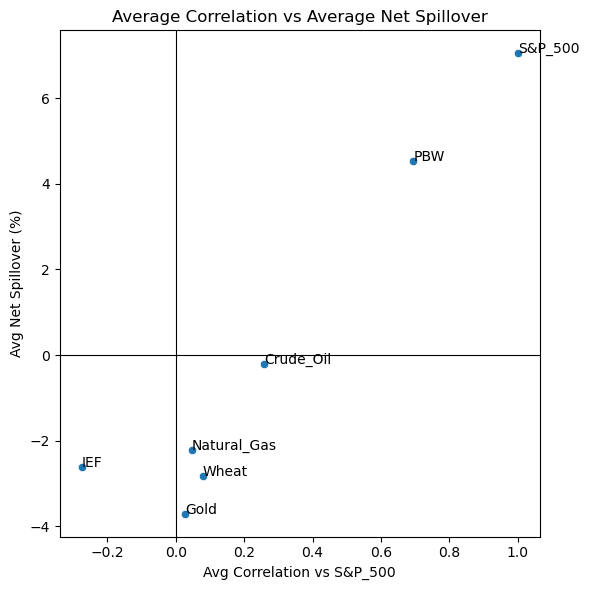

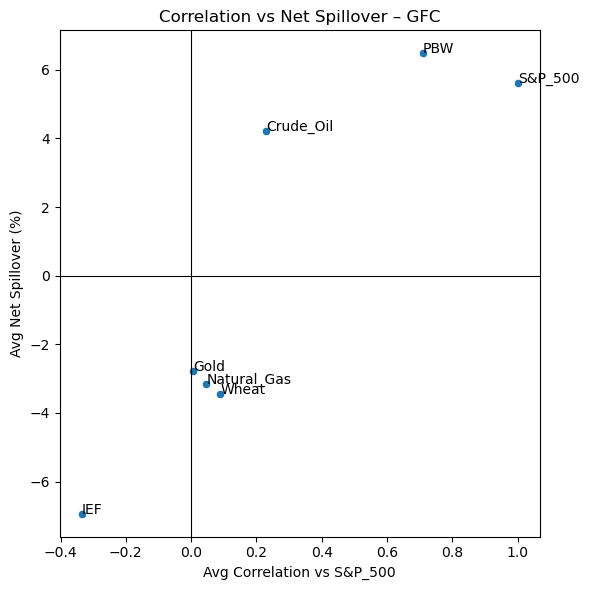

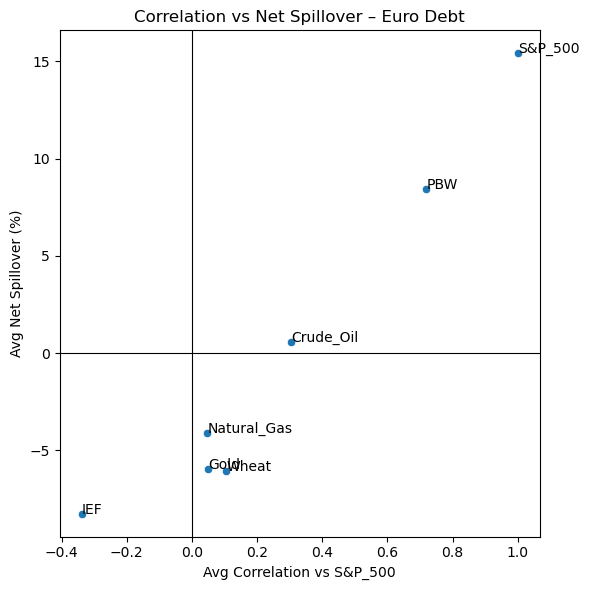

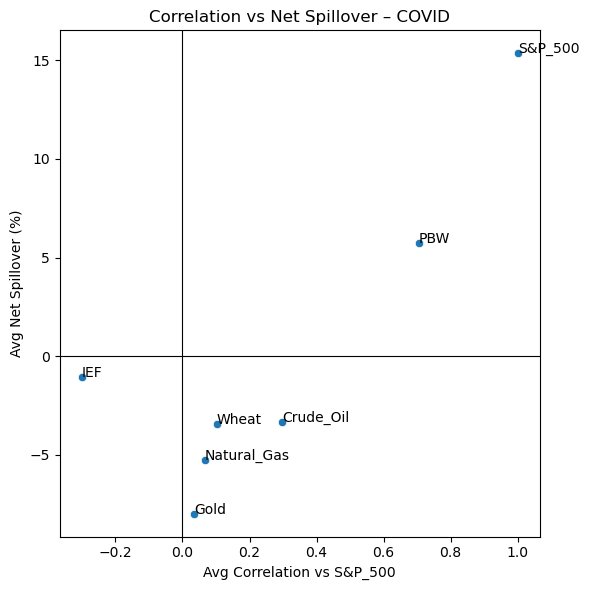

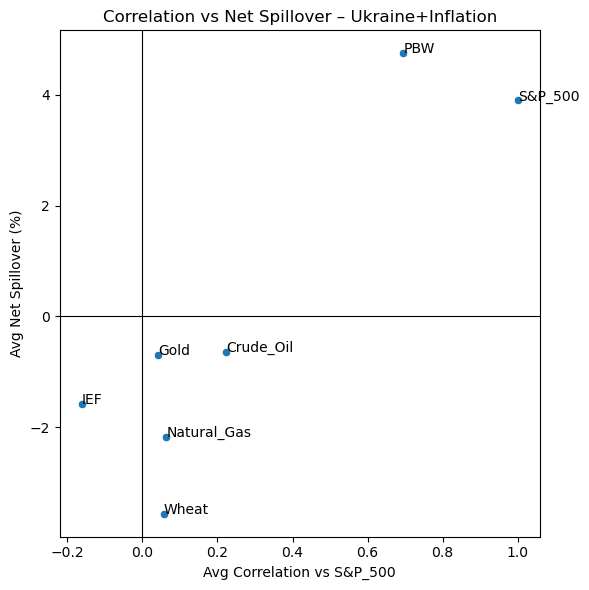

In [81]:
# === Alternative Spillover Visualisations ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Config
H, W, STEP, LAG_MODE = 10, 250, 5, "fixed"
ANCHOR = "S&P_500"
OUTDIR = Path("outputs/rolling")
DCC_FILE = Path("dcc_correlations.csv")

# Crisis shading windows
CRISES = [
    ("2007-07-01", "2009-06-30", "GFC"),
    ("2010-05-01", "2012-12-31", "Euro Debt"),
    ("2020-02-15", "2020-12-31", "COVID"),
    ("2022-02-01", "2023-12-31", "Ukraine+Inflation"),
]

# -----------------------
# Load rolling NET spillovers
# -----------------------
net_path = OUTDIR / f"rolling_net_H{H}_W{W}_S{STEP}_{LAG_MODE}.csv"
df_net = pd.read_csv(net_path, index_col=0, parse_dates=True)
assets = list(df_net.columns)

# -----------------------
# 1) Heatmap of rolling NET spillovers
# -----------------------
plt.figure(figsize=(12, 5))
sns.heatmap(df_net.T, cmap="coolwarm", center=0, cbar_kws={"label": "Net Spillover (%)"})
plt.title(f"Rolling Net Spillovers Heatmap (H={H}, W={W})")
plt.xlabel("Time")
plt.ylabel("Asset")
plt.tight_layout()
plt.savefig(OUTDIR / f"heatmap_net_spillovers_H{H}_W{W}.png", dpi=220)
plt.close()
print(f"[SAVED] Heatmap → {OUTDIR / f'heatmap_net_spillovers_H{H}_W{W}.png'}")

# -----------------------
# 2) Crisis-period average NET spillovers (bar chart)
# -----------------------
for start, end, label in CRISES:
    avg_net = df_net.loc[start:end].mean().sort_values()
    plt.figure(figsize=(8, 4))
    avg_net.plot(kind="barh", color=["red" if v > 0 else "blue" for v in avg_net])
    plt.axvline(0, color="black", lw=0.8)
    plt.title(f"Average Net Spillovers ({label})")
    plt.xlabel("Net Spillover (%)")
    plt.tight_layout()
    plt.savefig(OUTDIR / f"bar_net_spillovers_{label.replace(' ', '_')}.png", dpi=220)
    plt.close()
    print(f"[SAVED] {label} bar chart → {OUTDIR / f'bar_net_spillovers_{label.replace(' ', '_')}.png'}")

# -----------------------
# 3) Scatter plots: Correlation vs NET spillover
# -----------------------
# Load DCC correlations (long format; keep only Asset1 == ANCHOR)
dcc_long = pd.read_csv(DCC_FILE)
dcc_long["Date"] = pd.to_datetime(dcc_long["Date"], errors="coerce")
dcc_long = dcc_long.dropna(subset=["Date"])
dcc_anchor = dcc_long[dcc_long["Asset1"] == ANCHOR].copy()
dcc_wide = dcc_anchor.pivot_table(index="Date", columns="Asset2", values="Correlation", aggfunc="mean")
dcc_wide = dcc_wide.reindex(columns=assets, fill_value=np.nan)
dcc_wide = dcc_wide.reindex(df_net.index).interpolate(limit_direction="both").ffill().bfill()

# Overall scatter
mean_corr = dcc_wide.mean()
mean_net = df_net.mean()
plt.figure(figsize=(6, 6))
sns.scatterplot(x=mean_corr, y=mean_net)
for a in assets:
    plt.text(mean_corr[a], mean_net[a], a)
plt.axhline(0, color="black", lw=0.8)
plt.axvline(0, color="black", lw=0.8)
plt.title("Average Correlation vs Average Net Spillover")
plt.xlabel(f"Avg Correlation vs {ANCHOR}")
plt.ylabel("Avg Net Spillover (%)")
plt.tight_layout()
safe_label = label.replace(" ", "_").replace("/", "&")
plt.savefig(OUTDIR / f"scatter_corr_vs_net_{safe_label}.png", dpi=220)
print(f"[SAVED] {label} scatter → {OUTDIR / f'scatter_corr_vs_net_{safe_label}.png'}")



# Crisis-specific scatter
for start, end, label in CRISES:
    mean_corr_c = dcc_wide.loc[start:end].mean()
    mean_net_c = df_net.loc[start:end].mean()
    plt.figure(figsize=(6, 6))
    sns.scatterplot(x=mean_corr_c, y=mean_net_c)
    for a in assets:
        plt.text(mean_corr_c[a], mean_net_c[a], a)
    plt.axhline(0, color="black", lw=0.8)
    plt.axvline(0, color="black", lw=0.8)
    plt.title(f"Correlation vs Net Spillover – {label}")
    plt.xlabel(f"Avg Correlation vs {ANCHOR}")
    plt.ylabel("Avg Net Spillover (%)")
    plt.tight_layout()
    # Safe label for filenames
    safe_label = label.replace(" ", "_").replace("/", "&")
    plt.savefig(OUTDIR / f"bar_net_spillovers_{safe_label}.png", dpi=220)
    print(f"[SAVED] {label} bar chart → {OUTDIR / f'bar_net_spillovers_{safe_label}.png'}")



print("[DONE] All alternative visualisations saved.")


In [8]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def fixed_circle_positions(nodes, radius=1.0, start_angle_deg=90):
    """Deterministic even spacing on a circle."""
    nodes = list(nodes)
    n = len(nodes)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False) + np.deg2rad(start_angle_deg)
    return {node: (radius*np.cos(a), radius*np.sin(a)) for node, a in zip(nodes, angles)}

def plot_network(avg_mat, net_vals, title, outpath,
                 threshold=3.0, TOPN=5,
                 size_scale=55.0, size_cap=3200, edge_alpha=0.7,
                 global_topK=12):
    """
    Clean & robust spillover network:
      • manual circular positions (no spring surprises)
      • capped node sizes
      • auto threshold fallback then global top‑K
    """
    assets = list(avg_mat.index)
    # Build weighted directed graph
    G = nx.DiGraph()
    G.add_nodes_from(assets)

    # assemble edge list with initial threshold + topN per row
    edges = []
    for i in assets:
        row = avg_mat.loc[i, [j for j in assets if j != i]].sort_values(ascending=False)
        if TOPN is not None:
            row = row.head(TOPN)
        for j, w in row.items():
            if w >= threshold:
                edges.append((i, j, float(w)))

    # fallback: lower threshold
    thr_used = threshold
    while not edges and thr_used > 0:
        thr_used -= 0.5
        for i in assets:
            row = avg_mat.loc[i, [j for j in assets if j != i]].sort_values(ascending=False)
            if TOPN is not None:
                row = row.head(TOPN)
            for j, w in row.items():
                if w >= thr_used:
                    edges.append((i, j, float(w)))

    # fallback 2: global top-K if still empty
    if not edges:
        flat = []
        for i in assets:
            for j in assets:
                if i != j:
                    flat.append((i, j, float(avg_mat.loc[i, j])))
        flat.sort(key=lambda x: x[2], reverse=True)
        edges = flat[:global_topK]
        thr_used = 0.0

    G.add_weighted_edges_from(edges)

    # Node sizes (cap to avoid overlap)
    conn = {a: avg_mat.loc[a, :].sum() + avg_mat.loc[:, a].sum() for a in assets}
    sizes = [min(max(conn[a], 0.0) * size_scale, size_cap) for a in assets]

    # Node colors by NET sign
    node_colors = ["red" if net_vals.get(a, 0.0) > 0 else "blue" for a in assets]

    # **Fixed positions**
    pos = fixed_circle_positions(assets, radius=1.0, start_angle_deg=90)

    # Draw
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors,
                           edgecolors="black", linewidths=1.0, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold",
                            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1.5),
                            ax=ax)

    if G.number_of_edges() > 0:
        weights = [d["weight"] for *_ , d in G.edges(data=True)]
        widths = [max(w, 0.15)/2.2 for w in weights]
        ed = nx.draw_networkx_edges(
            G, pos, arrowstyle="->", arrowsize=14,
            edge_color=weights, edge_cmap=plt.cm.plasma,
            width=widths, alpha=edge_alpha, connectionstyle="arc3,rad=0.18", ax=ax
        )
        # Colorbar bound to the mappable from edges
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                                   norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Spillover (%)")

    ax.legend(
        handles=[mpatches.Patch(color="red", label="Net Transmitter (NET > 0)"),
                 mpatches.Patch(color="blue", label="Net Receiver (NET < 0)")],
        loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=2, frameon=True
    )

    ax.set_title(f"{title}\n(Threshold ≥ {thr_used:.1f}%, TopN={TOPN})", pad=16)
    ax.axis("off")
    plt.tight_layout()
    plt.savefig(outpath, dpi=240)
    plt.close()

print(f"\n[DIAGNOSTICS] {label}")
print(f" Date range: {sub_to.index.min().date()} → {sub_to.index.max().date()} | Obs: {len(sub_to)}")
print(f" TO min/max: {avg_to_vec.min():.3f} / {avg_to_vec.max():.3f}")
print(f" FROM min/max: {avg_from_vec.min():.3f} / {avg_from_vec.max():.3f}")
print(f" NET sum (should be ~0): {avg_net.sum():.6f}")
print(f" NET min/max: {avg_net.min():.3f} / {avg_net.max():.3f}")
print(f" % of TO entries >= {EDGE_THRESHOLD}: "
      f"{(avg_mat.values >= EDGE_THRESHOLD).mean()*100:.1f}%")


# ------------------
# Build & plot networks per crisis
# ------------------
for start, end, label in CRISES:
    sub_to   = df_to.loc[start:end]
    sub_from = df_from.loc[start:end]
    if sub_to.empty or sub_from.empty:
        print(f"[WARN] No data for {label}"); continue

    avg_to_vec   = sub_to.mean()
    avg_from_vec = sub_from.mean()
    avg_net      = avg_to_vec - avg_from_vec  # used for node colours

    # Approximate average TO matrix: split each asset's TO evenly across others
    avg_mat = pd.DataFrame(0.0, index=assets, columns=assets)
    K = len(assets)
    for i in assets:
        off = avg_to_vec[i] / (K - 1) if K > 1 else 0.0
        for j in assets:
            if i != j:
                avg_mat.loc[i, j] = off

    safe = safename(label)
    out = OUTDIR / f"network_avg_{safe}.png"
    plot_network(avg_mat, avg_net, f"Average Spillover Network – {label}", out)
    print(f"[SAVED] {out}")

print("[DONE] All crisis-average coloured networks created.]")



[DIAGNOSTICS] Ukraine&Inflation
 Date range: 2022-02-01 → 2023-12-29 | Obs: 97
 TO min/max: 6.614 / 41.117
 FROM min/max: 8.779 / 37.221
 NET sum (should be ~0): -0.000000
 NET min/max: -3.554 / 4.745
 % of TO entries >= 3.0: 61.2%
[SAVED] outputs/networks_avg_coloured/network_avg_GFC.png
[SAVED] outputs/networks_avg_coloured/network_avg_Euro_Debt.png
[SAVED] outputs/networks_avg_coloured/network_avg_COVID.png
[SAVED] outputs/networks_avg_coloured/network_avg_Ukraine&Inflation.png
[DONE] All crisis-average coloured networks created.]


In [107]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

# --- CONFIG ---
EDGE_THRESHOLD = 3.0
TOPN = 5
GLOBAL_TOPK = 12
SIZE_SCALE = 55.0
SIZE_CAP = 3200
EDGE_ALPHA = 0.7
OUTDIR = Path("outputs/networks_avg_diag")
OUTDIR.mkdir(parents=True, exist_ok=True)

def safename(s): return s.replace(" ", "_").replace("/", "&")

def fixed_circle_positions(nodes, radius=1.0, start_angle_deg=90):
    """Deterministic even spacing on a circle."""
    n = len(nodes)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False) + np.deg2rad(start_angle_deg)
    return {node: (radius*np.cos(a), radius*np.sin(a)) for node, a in zip(nodes, angles)}

def plot_network(avg_mat, net_vals, title, outpath,
                 threshold=EDGE_THRESHOLD, TOPN=TOPN,
                 size_scale=SIZE_SCALE, size_cap=SIZE_CAP,
                 edge_alpha=EDGE_ALPHA, global_topK=GLOBAL_TOPK):
    """Robust network plot with circular layout and threshold fallbacks."""
    assets = list(avg_mat.index)
    G = nx.DiGraph()
    G.add_nodes_from(assets)

    # Build edges with threshold + TOPN per node
    edges = []
    for i in assets:
        row = avg_mat.loc[i, [j for j in assets if j != i]].sort_values(ascending=False)
        if TOPN is not None:
            row = row.head(TOPN)
        for j, w in row.items():
            if w >= threshold:
                edges.append((i, j, float(w)))

    # Fallback 1: lower threshold
    thr_used = threshold
    while not edges and thr_used > 0:
        thr_used -= 0.5
        for i in assets:
            row = avg_mat.loc[i, [j for j in assets if j != i]].sort_values(ascending=False)
            if TOPN is not None:
                row = row.head(TOPN)
            for j, w in row.items():
                if w >= thr_used:
                    edges.append((i, j, float(w)))

    # Fallback 2: global top-K if still empty
    if not edges:
        flat = []
        for i in assets:
            for j in assets:
                if i != j:
                    flat.append((i, j, float(avg_mat.loc[i, j])))
        flat.sort(key=lambda x: x[2], reverse=True)
        edges = flat[:global_topK]
        thr_used = 0.0

    G.add_weighted_edges_from(edges)

    # Node sizes and colours
    conn = {a: avg_mat.loc[a, :].sum() + avg_mat.loc[:, a].sum() for a in assets}
    sizes = [min(max(conn[a], 0.0) * size_scale, size_cap) for a in assets]
    node_colors = ["red" if net_vals.get(a, 0.0) > 0 else "blue" for a in assets]

    pos = fixed_circle_positions(assets)

    # Draw
    fig, ax = plt.subplots(figsize=(8.5, 8.5))
    nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color=node_colors,
                           edgecolors="black", linewidths=1.0, ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold",
                            bbox=dict(facecolor="white", alpha=0.75, edgecolor="none", pad=1.5),
                            ax=ax)

    if G.number_of_edges() > 0:
        weights = [d["weight"] for *_ , d in G.edges(data=True)]
        widths = [max(w, 0.15)/2.2 for w in weights]
        nx.draw_networkx_edges(
            G, pos, arrowstyle="->", arrowsize=14,
            edge_color=weights, edge_cmap=plt.cm.plasma,
            width=widths, alpha=edge_alpha, connectionstyle="arc3,rad=0.18", ax=ax
        )
        sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma,
                                   norm=plt.Normalize(vmin=min(weights), vmax=max(weights)))
        sm.set_array([])
        cbar = plt.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Spillover (%)")

    # Set title with proper padding
    ax.set_title(f"{title}\n(Threshold ≥ {thr_used:.1f}%, TopN={TOPN})", pad=20)
    
    # Create legend in top right corner
    handles = [
        mpatches.Patch(color="red", label="Net Transmitter (NET > 0)"),
        mpatches.Patch(color="blue", label="Net Receiver (NET < 0)")
    ]
    ax.legend(
    handles=handles,
    loc='upper center',          # Use the top center of the legend as the anchor
    bbox_to_anchor=(0.5, -0.05), # Position it horizontally centered, just below the plot
    frameon=False,               # Optional: remove the frame for a cleaner look
    ncol=2                       # Arrange legend items in 2 columns (horizontally)
)

    ax.axis("off")
    plt.tight_layout()
    plt.savefig(outpath, dpi=240, bbox_inches='tight')  # bbox_inches='tight' ensures legend is included
    plt.close()

# --- Crisis loop with diagnostics ---
for start, end, label in CRISES:
    sub_to   = df_to.loc[start:end]
    sub_from = df_from.loc[start:end]

    if sub_to.empty or sub_from.empty:
        print(f"[WARN] {label}: empty slice.")
        continue

    avg_to_vec   = sub_to.mean()
    avg_from_vec = sub_from.mean()
    avg_net      = avg_to_vec - avg_from_vec

    # Build approx TO matrix
    assets = df_to.columns.tolist()
    avg_mat = pd.DataFrame(0.0, index=assets, columns=assets)
    K = len(assets)
    for i in assets:
        off = avg_to_vec[i] / (K - 1) if K > 1 else 0.0
        for j in assets:
            if i != j:
                avg_mat.loc[i, j] = off

    # Diagnostics
    print(f"\n[DIAGNOSTICS] {label}")
    print(f" Date range: {sub_to.index.min().date()} → {sub_to.index.max().date()} | Obs: {len(sub_to)}")
    print(f" TO min/max: {avg_to_vec.min():.3f} / {avg_to_vec.max():.3f}")
    print(f" FROM min/max: {avg_from_vec.min():.3f} / {avg_from_vec.max():.3f}")
    print(f" NET sum (should be ~0): {avg_net.sum():.6f}")
    print(f" NET min/max: {avg_net.min():.3f} / {avg_net.max():.3f}")
    print(f" % of TO entries >= {EDGE_THRESHOLD}: "
          f"{(avg_mat.values >= EDGE_THRESHOLD).mean()*100:.1f}%")

    # Plot
    safe = safename(label)
    out = OUTDIR / f"network_avg_{safe}.png"
    plot_network(avg_mat, avg_net, f"Average Spillover Network – {label}", out)
    print(f"[SAVED] {out}")


[DIAGNOSTICS] GFC
 Date range: 2007-07-05 → 2009-06-29 | Obs: 101
 TO min/max: 14.370 / 55.808
 FROM min/max: 17.528 / 50.199
 NET sum (should be ~0): -0.000000
 NET min/max: -6.931 / 6.478
 % of TO entries >= 3.0: 61.2%
[SAVED] outputs/networks_avg_diag/network_avg_GFC.png

[DIAGNOSTICS] Euro Debt
 Date range: 2010-05-06 → 2012-12-26 | Obs: 134
 TO min/max: 5.334 / 75.145
 FROM min/max: 9.447 / 59.726
 NET sum (should be ~0): -0.000000
 NET min/max: -8.255 / 15.418
 % of TO entries >= 3.0: 49.0%
[SAVED] outputs/networks_avg_diag/network_avg_Euro_Debt.png

[DIAGNOSTICS] COVID
 Date range: 2020-02-20 → 2020-12-29 | Obs: 44
 TO min/max: 5.603 / 66.078
 FROM min/max: 9.054 / 53.362
 NET sum (should be ~0): 0.000000
 NET min/max: -7.980 / 15.350
 % of TO entries >= 3.0: 49.0%
[SAVED] outputs/networks_avg_diag/network_avg_COVID.png

[DIAGNOSTICS] Ukraine&Inflation
 Date range: 2022-02-01 → 2023-12-29 | Obs: 97
 TO min/max: 6.614 / 41.117
 FROM min/max: 8.779 / 37.221
 NET sum (should be ~0

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt

# -----------------------
# 0) Load log returns
# -----------------------
CANDIDATES = [
    "all_assets_log_returns_cleaned.csv",
    "data/all_assets_log_returns_cleaned.csv",
    "/mnt/data/all_assets_log_returns_cleaned.csv",
]
FILE = next((p for p in CANDIDATES if Path(p).exists()), None)
if FILE is None:
    raise FileNotFoundError("Update path to 'all_assets_log_returns_cleaned.csv'.")

df = pd.read_csv(FILE, index_col=0, parse_dates=True)
df.index.name = "Date"
df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")

# Optional study window
df = df.loc["2005-01-01":]

print(f"[LOAD] returns shape={df.shape}, span=({df.index.min().date()} → {df.index.max().date()})")
print("[LOAD] assets:", list(df.columns))

# -----------------------
# 1) Utilities
# -----------------------
def ensure_clean_panel(x: pd.DataFrame, min_obs: int = 1500) -> pd.DataFrame:
    x = x.sort_index().copy()
    ok = [c for c in x.columns if x[c].dropna().shape[0] >= min_obs]
    x = x[ok].dropna(how="any")
    x = x.loc[:, x.var() > 0]
    return x

def stationarity_report(x: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for c in x.columns:
        s = x[c].dropna()
        if s.nunique() < 3 or len(s) < 20:
            rows.append({"asset": c, "adf_stat": np.nan, "pvalue": np.nan,
                         "usedlag": np.nan, "nobs": len(s)})
            continue
        stat, p, usedlag, nobs, crit, icbest = adfuller(s.values, regression="c", autolag="AIC")
        rows.append({"asset": c, "adf_stat": float(stat), "pvalue": float(p),
                     "usedlag": int(usedlag), "nobs": int(nobs)})
    return pd.DataFrame(rows).set_index("asset").sort_values("pvalue")

def select_var_lag_ic(x: pd.DataFrame, maxlags: int = 15) -> int:
    sel = VAR(x).select_order(maxlags=maxlags)
    def _best(v):
        if v is None:
            return None
        arr = np.asarray(v)
        if arr.ndim == 0:
            return 1
        return int(arr.argmin() + 1)
    for pref in ["bic", "hqic", "aic", "fpe"]:
        b = _best(getattr(sel, pref, None))
        if b is not None and b > 0:
            return b
    return 1

def stability_report(var_res, outdir="outputs/var_stage"):
    roots = np.asarray(var_res.roots, dtype=complex)
    mod = np.abs(roots)
    rho = float(mod.max())
    is_stable = (mod > 1).all()
    Path(outdir).mkdir(parents=True, exist_ok=True)
    pd.DataFrame({
        "root_real": np.real(roots),
        "root_imag": np.imag(roots),
        "modulus": mod
    }).sort_values("modulus", ascending=False).to_csv(Path(outdir) / "companion_roots.csv", index=False)
    print("\n[STABILITY REPORT]")
    print("Stable VAR?            ", is_stable)
    print("Max modulus (ρ)        ", round(rho, 6))
    print("Min modulus            ", round(float(mod.min()), 6))
    return is_stable, rho

# -----------------------
# 2) Clean, stationarity, lag, VAR fit
# -----------------------
panel = ensure_clean_panel(df, min_obs=1500)
print(f"[CLEAN] panel shape={panel.shape}")

adf_rep = stationarity_report(panel)
print("\n[ADF] (first 5 rows)\n", adf_rep.head())

lag = select_var_lag_ic(panel, maxlags=15)
print(f"\n[LAG] Using lag={lag} from IC selection.")

var_res = VAR(panel).fit(lag)
stable, rho = stability_report(var_res)

# -----------------------
# 3) Generalized FEVD (Pesaran–Shin) at horizon H
# -----------------------
def generalized_fevd(var_res, H: int = 10) -> pd.DataFrame:
    Sigma = np.asarray(var_res.sigma_u, dtype=float)
    Psi = np.asarray(var_res.ma_rep(H), dtype=float)
    K = Sigma.shape[0]
    fevd = np.zeros((K, K), dtype=float)
    denom = np.zeros(K, dtype=float)
    for h in range(H):
        A = Psi[h] @ Sigma @ Psi[h].T
        denom += np.diag(A)
    sigma_diag = np.diag(Sigma)
    for i in range(K):
        for j in range(K):
            num = 0.0
            for h in range(H):
                v = (Psi[h] @ Sigma)[:, j]
                num += (v[i]) ** 2
            fevd[i, j] = (num / sigma_diag[j]) / denom[i] if denom[i] > 0 else np.nan
    names = var_res.model.endog_names
    return pd.DataFrame(fevd, index=names, columns=names)

H = 10
G = generalized_fevd(var_res, H=H)
G_norm = G.div(G.sum(axis=1), axis=0)
row_sums = G_norm.sum(axis=1).to_numpy()
print("\n[CHECK] Row sums (should be 1.0):", np.round(row_sums, 6))
print("[CHECK] Max |row_sum - 1|:", float(np.max(np.abs(row_sums - 1.0))))

# -----------------------
# 4) Diebold–Yilmaz spillover indices
# -----------------------
S = 100.0 * G_norm
K = S.shape[0]
off_diag_sum = S.values.sum() - np.trace(S.values)
total_spillover = off_diag_sum / K

directional_from = S.sum(axis=1) - np.diag(S.values)
directional_to = S.sum(axis=0) - np.diag(S.values)
net_spillover = directional_to - directional_from

print(f"\n[TOTAL SPILLOVER] (H={H}): {total_spillover:.2f}%")
print("\n[DIRECTIONAL FROM] (% of i's variance due to others):")
print(directional_from.round(2).to_string())
print("\n[DIRECTIONAL TO] (% of others' variance due to i):")
print(directional_to.round(2).to_string())
print("\n[NET SPILLOVER] (TO - FROM):")
print(net_spillover.round(2).to_string())

# -----------------------
# 5) Save all outputs
# -----------------------
out_sp = Path("outputs/spillovers")
out_var = Path("outputs/var_stage")
out_sp.mkdir(parents=True, exist_ok=True)
out_var.mkdir(parents=True, exist_ok=True)

with open(out_var / "var_summary.txt", "w") as f:
    f.write(str(var_res.summary()))
adf_rep.to_csv(out_var / "adf_report.csv")
G.to_csv(out_sp / f"gfevd_raw_H{H}.csv")
G_norm.to_csv(out_sp / f"gfevd_row_normalized_H{H}.csv")
S.to_csv(out_sp / f"spillover_table_percent_H{H}.csv")
pd.DataFrame({
    "Directional_FROM": directional_from,
    "Directional_TO": directional_to,
    "Net": net_spillover
}).to_csv(out_sp / f"spillover_indices_H{H}.csv")

# -----------------------
# 6) Quick visuals (PNG)
# -----------------------
plt.figure(figsize=(8, 6))
plt.imshow(S.values, aspect='auto')
plt.xticks(ticks=range(K), labels=S.columns, rotation=45, ha='right')
plt.yticks(ticks=range(K), labels=S.index)
plt.title(f"Spillover Table (%), H={H}")
plt.colorbar()
plt.tight_layout()
plt.savefig(out_sp / f"spillover_heatmap_H{H}.png", dpi=200)
plt.close()

plt.figure(figsize=(8, 4.5))
(net_spillover.sort_values()).plot(kind="bar")
plt.title("Net Spillovers (TO - FROM), %")
plt.tight_layout()
plt.savefig(out_sp / "net_spillovers_bar.png", dpi=200)
plt.close()

# -----------------------
# 7) Load rolling spillover files and compute summary statistics
# -----------------------
def compute_rolling_summary_stats(file_paths, outdir="outputs/rolling"):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    summary_stats = {}
    
    for file_path in file_paths:
        try:
            # Load the rolling spillover CSV
            df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")
            
            # Compute summary statistics for each column (asset)
            stats = df.describe()  # Includes count, mean, std, min, 25%, 50%, 75%, max
            file_name = Path(file_path).stem
            summary_stats[file_name] = stats
            
            # Save summary statistics to CSV
            stats.to_csv(Path(outdir) / f"{file_name}_summary_stats.csv")
            print(f"\n[SUMMARY STATS] Saved for {file_name} to {Path(outdir) / f'{file_name}_summary_stats.csv'}")
            print(f"\n[SUMMARY STATS] {file_name}:\n", stats.round(2).to_string())
            
        except FileNotFoundError:
            print(f"[ERROR] File not found: {file_path}")
        except Exception as e:
            print(f"[ERROR] Failed to process {file_path}: {e}")
    
    return summary_stats

# File paths for rolling spillover data
rolling_files = [
    "outputs/rolling/rolling_from_H10_W250_S5_fixed.csv",
    "outputs/rolling/rolling_to_H10_W250_S5_fixed.csv",
    "outputs/rolling/rolling_net_H10_W250_S5_fixed.csv"
]

# Compute and save summary statistics
compute_rolling_summary_stats(rolling_files)

print(f"\n[SAVED] All outputs → {out_sp.resolve()} and {out_var.resolve()}")
print("[DONE]")

[LOAD] returns shape=(5093, 7), span=(2005-03-04 → 2025-06-27)
[LOAD] assets: ['S&P_500', 'IEF', 'Gold', 'Wheat', 'Natural_Gas', 'Crude_Oil', 'PBW']
[CLEAN] panel shape=(5093, 7)

[ADF] (first 5 rows)
           adf_stat        pvalue  usedlag  nobs
asset                                          
IEF     -53.453110  0.000000e+00        1  5091
Gold    -24.334944  0.000000e+00        8  5084
Wheat   -70.614082  0.000000e+00        0  5092
PBW     -21.755480  0.000000e+00        9  5083
S&P_500 -18.036503  2.666070e-30       15  5077


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[LAG] Using lag=1 from IC selection.

[STABILITY REPORT]
Stable VAR?             True
Max modulus (ρ)         73.634734
Min modulus             6.730671

[CHECK] Row sums (should be 1.0): [1. 1. 1. 1. 1. 1. 1.]
[CHECK] Max |row_sum - 1|: 4.440892098500626e-16

[TOTAL SPILLOVER] (H=10): 20.70%

[DIRECTIONAL FROM] (% of i's variance due to others):
S&P_500        42.50
IEF            17.12
Gold            9.64
Wheat           7.80
Natural_Gas     4.27
Crude_Oil      22.53
PBW            41.01

[DIRECTIONAL TO] (% of others' variance due to i):
S&P_500        48.86
IEF            13.56
Gold            7.89
Wheat           6.43
Natural_Gas     3.32
Crude_Oil      21.17
PBW            43.65

[NET SPILLOVER] (TO - FROM):
S&P_500        6.36
IEF           -3.56
Gold          -1.75
Wheat         -1.37
Natural_Gas   -0.95
Crude_Oil     -1.36
PBW            2.64


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



[SUMMARY STATS] Saved for rolling_from_H10_W250_S5_fixed to outputs/rolling/rolling_from_H10_W250_S5_fixed_summary_stats.csv

[SUMMARY STATS] rolling_from_H10_W250_S5_fixed:
        S&P_500     IEF    Gold   Wheat  Natural_Gas  Crude_Oil     PBW
count   969.00  969.00  969.00  969.00       969.00     969.00  969.00
mean     44.55   27.95   20.67   11.90         9.47      27.64   43.68
std      10.38   12.77    7.70    9.61         6.20      13.69    9.81
min      21.15    1.34    5.69    1.62         0.58       3.86   20.76
25%      37.09   18.74   14.58    4.95         5.05      18.45   36.39
50%      44.00   28.56   19.28    8.25         7.48      23.13   43.50
75%      52.18   37.08   27.57   16.59        12.26      38.07   52.64
max      62.96   53.63   44.51   41.98        31.78      55.95   62.07

[SUMMARY STATS] Saved for rolling_to_H10_W250_S5_fixed to outputs/rolling/rolling_to_H10_W250_S5_fixed_summary_stats.csv

[SUMMARY STATS] rolling_to_H10_W250_S5_fixed:
        S&P_500 

In [25]:
# Add this to the end of the `compute_rolling_summary_stats` function or as a separate function
def plot_rolling_spillovers(file_paths, outdir="outputs/rolling"):
    Path(outdir).mkdir(parents=True, exist_ok=True)
    
    for file_path in file_paths:
        try:
            df = pd.read_csv(file_path, index_col=0, parse_dates=True)
            df = df.apply(pd.to_numeric, errors="coerce").dropna(how="any")
            
            plt.figure(figsize=(10, 6))
            for column in df.columns:
                plt.plot(df.index, df[column], label=column)
            plt.title(f"Rolling {Path(file_path).stem.replace('_H10_W250_S5_fixed', '')} Spillovers Over Time")
            plt.xlabel("Date")
            plt.ylabel("Spillover (%)")
            plt.legend()
            plt.tight_layout()
            plot_path = Path(outdir) / f"{Path(file_path).stem}_plot.png"
            plt.savefig(plot_path, dpi=200)
            plt.close()
            print(f"[PLOT] Saved rolling spillover plot to {plot_path}")
        except Exception as e:
            print(f"[ERROR] Failed to plot {file_path}: {e}")

# Add to the end of the script, after compute_rolling_summary_stats
plot_rolling_spillovers(rolling_files)

[PLOT] Saved rolling spillover plot to outputs/rolling/rolling_from_H10_W250_S5_fixed_plot.png
[PLOT] Saved rolling spillover plot to outputs/rolling/rolling_to_H10_W250_S5_fixed_plot.png
[PLOT] Saved rolling spillover plot to outputs/rolling/rolling_net_H10_W250_S5_fixed_plot.png
